# Laboratório - Aproximador de funções

## Integrantes
| Nomes                             | R.A          |
|-----------------------------------|--------------|
| Andy Silva Barbosa                | 22.218.025-9 |
| Rafael Zacarias Palierini         | 22.218.030-9 |
| Rubens de Araujo Rodrigues Mendes | 22.218.009-3 |
| Vitor Acosta da Rosa              | 22.218.006-9 |

# Imports das libs utilizadas

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Código de preparação da base

Aqui, a base será baixada e algumas variáveis utilitárias serão estabelecidas.


In [144]:
#Baixa os arquivos do dataset
lfw_people = fetch_lfw_people('data', min_faces_per_person=100)

# Gera os arrays das imagens para os plots
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# Aqui, os dados são passados diretamente para as features
X = lfw_people.data
n_features = X.shape[1]

# Os rótulos para predição
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("Número de exemplos: %d" % n_samples)
print("Número de características: %d" % n_features)
print("Número de classes: %d" % n_classes)
print("Classes: ",target_names)

Total dataset size:
Número de exemplos: 1140
Número de características: 2914
Número de classes: 5
Classes:  ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


# Plot das imagens

Aqui será realizado o plot de algumas imagens exemplo, com o intuito de avaliar se foram importadas corretamente.


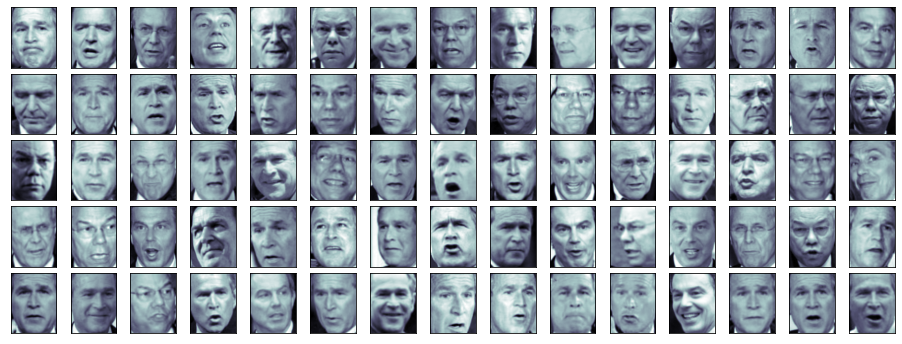

In [145]:
fig, axes = plt.subplots(5, 15, figsize=(16,6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    imagem = X[i]
    ax.imshow( imagem.reshape(h, w)  , cmap='bone')

# Utilização de componentes 

Aqui serão feitas as manipulações relacionadas aos componentes, para utilizarmos o PCA.

Como podemos ver, mantendo uma numeração de 450 componentes pouca informação foi perdida.

Extraindo as primeiras 450 eigenfaces das 1140 faces


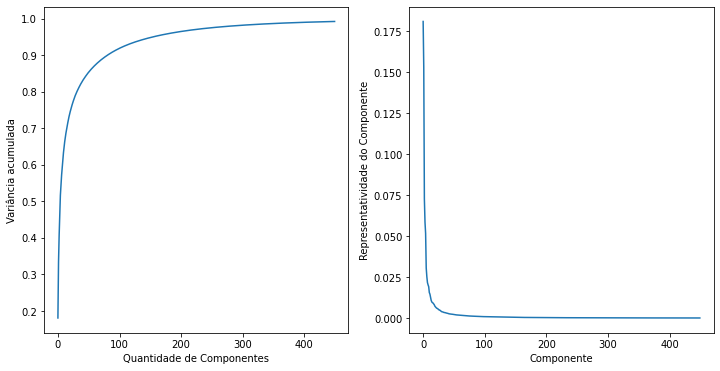

In [147]:
#Número de componentes de característica da imagem
n_components = 450

print("Extraindo as primeiras %d eigenfaces das %d faces" % (n_components, X.shape[0]) )
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

pca = pca.fit(X)

fig, axes = plt.subplots(1,2, figsize=(12,6))

#Quantidade de informação mantida na imagem
axes[0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0].set(xlabel='Quantidade de Componentes', ylabel = 'Variância acumulada')

#Impacto do componente na imagem
axes[1].plot(pca.explained_variance_ratio_)
axes[1].set(xlabel='Componente', ylabel = 'Representatividade do Componente')
plt.show()

# Geração de *eigenfaces*

Eigenfaces é o conjunto de autovetores de uma matriz de covariância formada por imagens de faces (rostos). Esta técnica foi desenvolvida por Sirovich e Kirby para representar padrões encontrados em imagens de rostos utilizando o método de PCA, pois leva em conta o número de componentes mantidos na imagem.

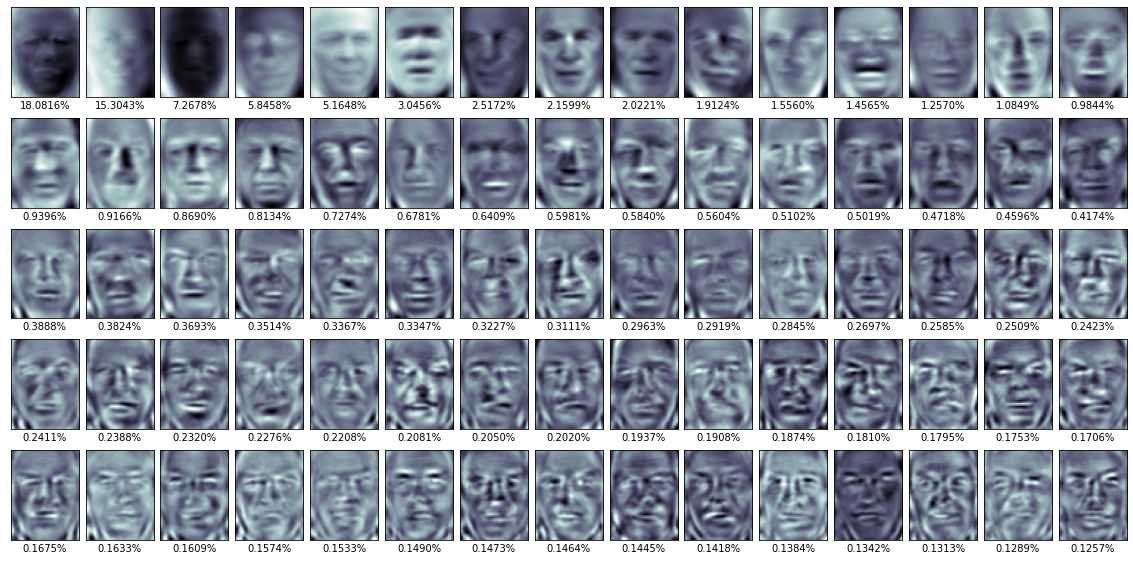

In [148]:
eigenfaces = pca.components_.reshape((n_components, h, w))


fig, axes = plt.subplots(5,15, figsize=(20,10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='bone')
    ax.set_xlabel('%6.4f%%'%(pca.explained_variance_ratio_[i]*100))

# Exemplo de imagem 

Amostra da base de dados para análise da informação mantida na imagem após diminuição dos componentes.

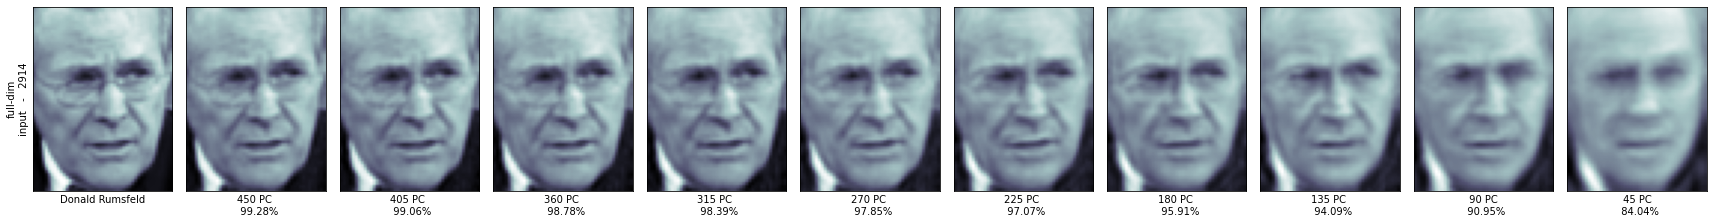

In [149]:
QttdComponents = list(range(n_components,1,-(n_components-1)//10))
Imagem = 40

fig, ax = plt.subplots(1, len(QttdComponents)+1, figsize=(30,10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
ax[0].imshow(X[Imagem].reshape(h,w), cmap='bone')
ax[0].set_ylabel('full-dim\ninput   -   %d'%(len(X[i])))
ax[0].set_xlabel(target_names[y[Imagem]])

for i in range(len(QttdComponents)):
  pca = PCA(QttdComponents[i], whiten=True, svd_solver='randomized')
  pca = pca.fit(X)
  components = pca.transform(X[[Imagem]])
  projected = pca.inverse_transform(components)
  
  ax[i+1].imshow(projected.reshape(h,w), cmap='bone')
  ax[i+1].set_xlabel('%3d PC \n %6.2f%%'%(QttdComponents[i],sum(pca.explained_variance_ratio_)*100))

# Início da classificação das imagens

Separação da base em sets de treino e teste

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Criação de um novo PCA com 150 componentes para os splits de treino e teste e base completa. Esse valor foi escolhido pois através de testes, demonstrou melhor resultado em relação aos 300/450 componentes

In [181]:
n_components = 150

pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

pca_train = pca.fit(X_train)

X_train_pca = pca_train.transform(X_train)
X_test_pca = pca_train.transform(X_test)

pca_x = pca.fit(X)

x = pca_x.transform(X)

Criação do modelo MLPClassifier

In [178]:
"""
Função que cria o modelo e o retorna
"""

def MLPModel(hidden_layer_tuple, num_iter, act_func):
  model = MLPClassifier(hidden_layer_sizes=tuple(hidden_layer_tuple),
                       activation = act_func,
                       max_iter = num_iter,
                       solver="adam",
                       learning_rate="adaptive",
                       n_iter_no_change = 1000
                      )
  
  return model

Treino do modelo MLPClassifier apenas para o set de treino, o valor das layers e quantidade de iterações foi escolhida por meio de tentativa e erro seguido de um refinamento nos parâmetros.


In [182]:
model = MLPModel((128,256,256,128), 10000, "relu")
model_clf = model.fit(X_train_pca, y_train)

Resultados para o set de teste da base aplicando-se a matriz de confusão e reports da classificação.



                   precision    recall  f1-score   support

     Colin Powell       0.85      0.92      0.88        37
  Donald Rumsfeld       0.94      0.75      0.83        20
    George W Bush       0.93      0.95      0.94        78
Gerhard Schroeder       0.80      0.63      0.71        19
       Tony Blair       0.75      0.88      0.81        17

         accuracy                           0.88       171
        macro avg       0.85      0.83      0.83       171
     weighted avg       0.88      0.88      0.87       171



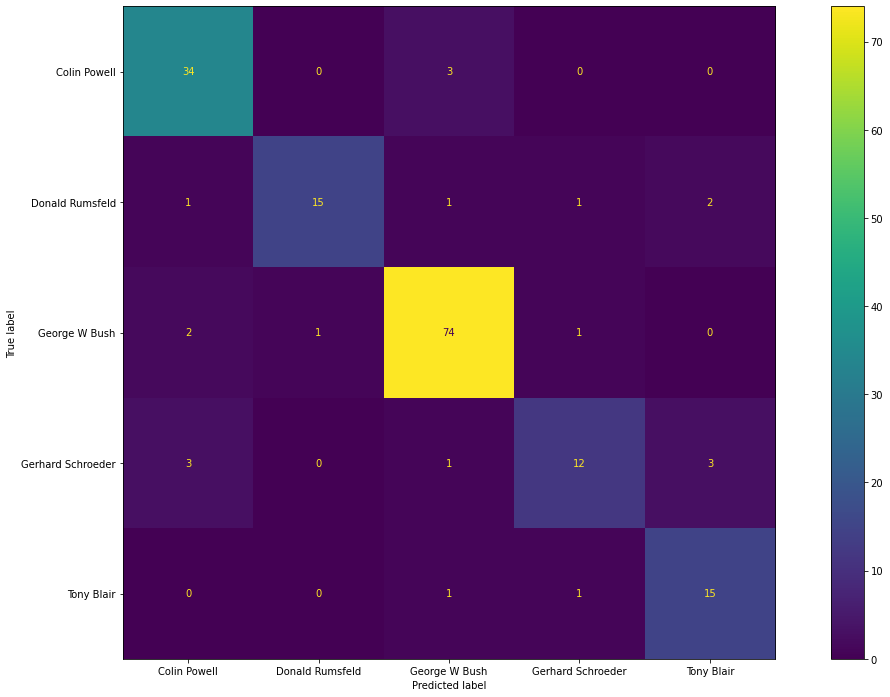

In [184]:
y_pred = model_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(20, 12))
plot_confusion_matrix(model_clf,X_test_pca,y_test,ax=ax, display_labels=target_names, include_values=True, values_format='d')

Criação do PCA e treino do modelo MLPClassifier para a base inteira

In [185]:
model = MLPModel((15,15), 2500 , "relu")
model_clf = model.fit(x, y)

Resultados para a base inteira

                   precision    recall  f1-score   support

     Colin Powell       1.00      1.00      1.00       236
  Donald Rumsfeld       1.00      1.00      1.00       121
    George W Bush       1.00      1.00      1.00       530
Gerhard Schroeder       1.00      1.00      1.00       109
       Tony Blair       1.00      1.00      1.00       144

         accuracy                           1.00      1140
        macro avg       1.00      1.00      1.00      1140
     weighted avg       1.00      1.00      1.00      1140



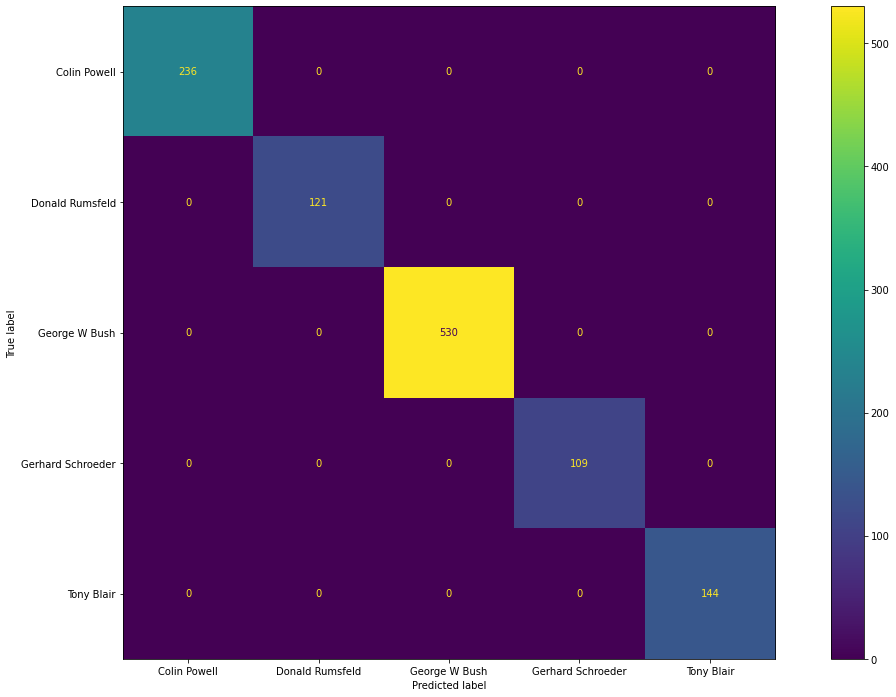

In [186]:
y_pred = model_clf.predict(x)
print(classification_report(y, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(20, 12))
plot_confusion_matrix(model_clf,x,y,ax=ax, display_labels=target_names, include_values=True, values_format='d')